In [1]:
from keras import datasets
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras import models
from keras.layers import Dense, Activation, Conv2D, Flatten
from keras.optimizers import Adam
import math
import cv2

Using TensorFlow backend.


Mnist data load

In [2]:
(x_train, y_train), (x_test, y_test) = datasets.mnist.load_data()

In [3]:
y_train = keras.utils.to_categorical(y_train)
y_test = keras.utils.to_categorical(y_test)

In [4]:
x_train.shape, y_train.shape

((60000, 28, 28), (60000, 10))

In [5]:
x_train = x_train.reshape(-1, 28, 28, 1)
x_test = x_test.reshape(-1, 28, 28, 1)

x_train = x_train / 255.0
x_test = x_test / 255.0

In [6]:
x_train.shape, y_train.shape

((60000, 28, 28, 1), (60000, 10))

Simple CNN Network build

In [7]:
def build_net():
    model = models.Sequential()
    model.add(Conv2D(16, (3,3), padding = 'same', input_shape = (28, 28, 1)))
    model.add(Activation('relu'))
    model.add(Flatten())
    model.add(Dense(10))
    model.add(Activation('softmax'))
    
    model.compile(loss = 'categorical_crossentropy', optimizer = Adam(lr = 0.001)
                          ,metrics = ['accuracy'])
    return model

In [8]:
mnist_net = build_net()

In [9]:
class DataGenerator:
    def __init__(self, x_set, y_set, x_shape, y_shape, batch_size, do_shuffle, do_augment):
        self.x_set = x_set
        self.y_set = y_set
        self.total_batch = x_shape[0]
        self.img_h = x_shape[1]
        self.img_w = x_shape[2]
        self.img_c = x_shape[3]
        self.class_num = y_shape[1]
        self.batch_size = batch_size
        self.do_shuffle = do_shuffle
        self.do_augment = do_augment
        
    def change_brightness(self, img, brightness_range = np.random.uniform(0, 0.2)):
        # convert BGR to HSV  colorspace
        # randomly change the brightness of image
        if self.img_c < 3:
            img = np.resize(img, (self.img_h, self.img_w, 3))
        img = np.asarray(img, dtype=np.float32)
        hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
        rand = brightness_range
        hsv[:, :, 2] = rand*hsv[:, :, 2]
        new_img = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)
        # new_img = cv2.cvtColor(new_img, cv2.COLOR_BGR2GRAY)
        new_img = np.resize(new_img, (self.img_h, self.img_w, self.img_c))

        return new_img 
    
    def zoom(self, img, zoom_range = np.random.randint(0, 10)):
        # image zoom
        zoom_pix = zoom_range
        zoom_factor = 1 + (2*zoom_pix)/self.img_h
        image = cv2.resize(img, None, fx=zoom_factor,
                           fy=zoom_factor, interpolation=cv2.INTER_LINEAR)
        top_crop = (image.shape[0] - self.img_h)//2
        left_crop = (image.shape[1] - self.img_w)//2
        new_img = image[top_crop: top_crop+self.img_h,
                      left_crop: left_crop+self.img_w].reshape([self.img_h, self.img_w, self.img_c])
        
        return new_img

    def get_data(self, index):
        if self.do_augment == True:
            do_zoom = np.random.randint(0,2,1)
            if do_zoom == 1:
                X, Y = self.zoom(self.x_set[index]),self.y_set[index]
            else:
                X, Y = self.change_brightness(self.x_set[index]),self.y_set[index]
        else:
            X, Y = self.x_set[index],self.y_set[index]
        return X, Y
        
    def generator(self):
        while True:
            if self.do_shuffle == True:
                idx_arr = np.random.permutation(self.total_batch)
            else:
                idx_arr = np.arange(self.total_batch)
            
            for batch in range(0, len(idx_arr), self.batch_size):
                l_bound = batch
                r_bound = batch + self.batch_size
                
                if r_bound > len(idx_arr):
                    r_bound = len(idx_arr)
                    l_bound = r_bound - self.batch_size
                
                current_batch = idx_arr[l_bound:r_bound]
                
                x_data = np.empty([self.batch_size, self.img_h, self.img_w, self.img_c], dtype = np.float32)
                y_data = np.empty([self.batch_size, self.class_num], dtype = np.int32)
               
                for i, v in enumerate(current_batch):
                    x_data[i], y_data[i] = self.get_data(v)                               
                yield (x_data, y_data)
            

In [10]:
params = {'x_set' : x_train, 'y_set' : y_train, 'x_shape' : x_train.shape,
              'y_shape' : y_train.shape, 'batch_size' : 128, 'do_shuffle' : False, 'do_augment' : True}

In [11]:
datagen = DataGenerator(**params)

In [12]:
mnist_net.fit_generator(datagen.generator(), steps_per_epoch = params['x_shape'][0] / params['batch_size'], epochs = 2)

Epoch 1/2
469/468 [==============================] - 5s 12ms/step - loss: 0.6712 - acc: 0.8297
Epoch 2/2
469/468 [==============================] - 3s 6ms/step - loss: 0.2854 - acc: 0.9202


In [13]:
result = mnist_net.evaluate(x_test,y_test)

10000/10000 [==============================] - 0s 45us/step


In [14]:
print('Test Loss : ', result[0])
print('Test Accuracy : ', result[1]*100, '%')

Test Loss :  0.5879237761139869
Test Accuracy :  83.96000000000001 %


In [15]:
datax,datay = next(datagen.generator())

In [16]:
datax.shape

(128, 28, 28, 1)

In [17]:
check_num = 1

different range

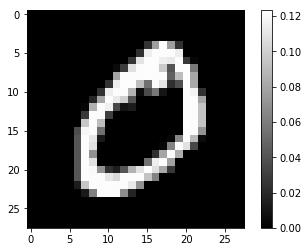

In [18]:
plt.imshow(np.squeeze(datax[check_num]), cmap = 'gray')
plt.colorbar()

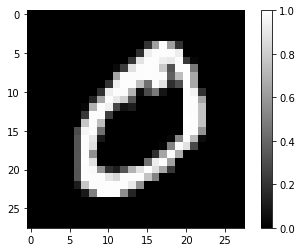

In [19]:
plt.imshow(np.squeeze(x_train[check_num]), cmap = 'gray')
plt.colorbar()